In [16]:
import os 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split

# Dataset 
https://bcsiriuschen.github.io/CARC/

In [17]:
path_dataset = "./CACD2000"

In [18]:
files = sorted(os.listdir(path_dataset))
len(files)

163446

In [19]:
def process_files(files):
    data = []
    for file in files:
        example = {}
        details = file.split('_')
     
        example['age'] = int(details[0])
        example['name'] = ' '.join(details[1:-1])
        example['file'] = file
        
        data.append(example)
    
    data = pd.DataFrame(data)
    return data


data = process_files(files)
data.head()

,age,name,file
0,14,Aaron Johnson,14_Aaron_Johnson_0001.jpg
1,14,Aaron Johnson,14_Aaron_Johnson_0002.jpg
2,14,Adelaide Kane,14_Adelaide_Kane_0001.jpg
3,14,Adelaide Kane,14_Adelaide_Kane_0002.jpg
4,14,Adelaide Kane,14_Adelaide_Kane_0003.jpg


In [20]:
data['name'].unique().size  # Names are unique [should be 2000 celebs]

2000

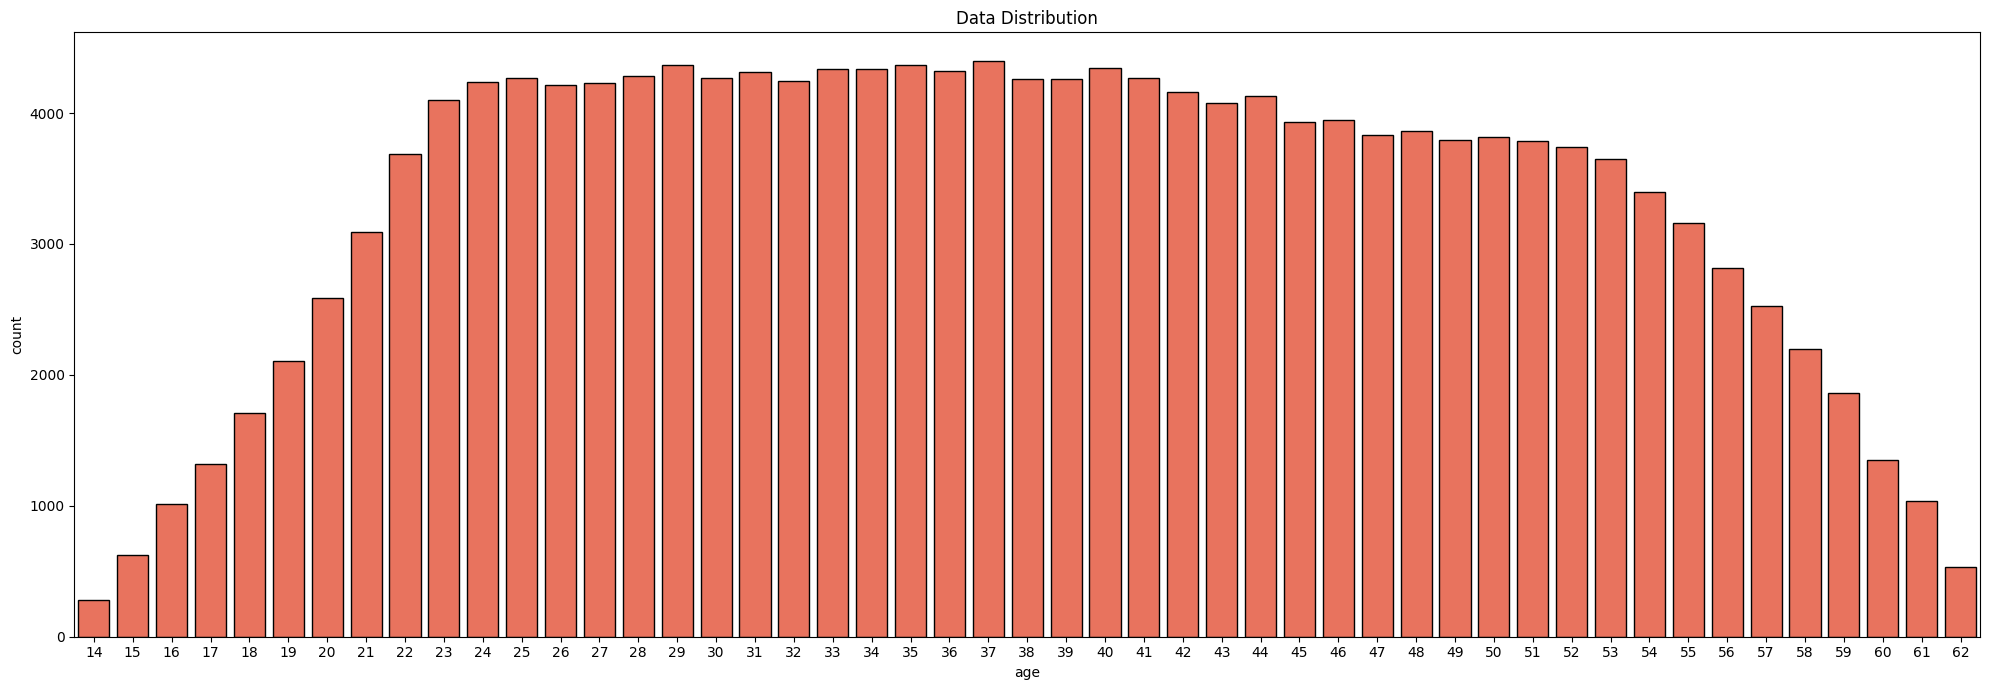

In [21]:
plt.figure(figsize=(20, 7))
sns.countplot(x='age', data=data, color='tomato', width=0.8, edgecolor='black')
plt.title('Data Distribution')
plt.tight_layout()

In [22]:
np.random.seed(42)
data['age_bin'] = pd.cut(data['age'], bins=[13, 23, 33, 43, 52, 62], labels=False)
grouped = data.groupby('name')['age_bin'].agg(lambda x: x.mode()[0])
name_df = pd.DataFrame(grouped).reset_index()

In [23]:
label_to_bin = {
    0: '13_to_22',
    1: '23_to_32',
    2: '33_to_42',
    3: '43_to_52',
    4: '53_to_62'
}

In [24]:
train_names, test_names = train_test_split(name_df['name'], test_size=0.2, stratify=name_df['age_bin'], random_state=42)

In [25]:
train_data = data[data['name'].isin(train_names)]
test_data = data[data['name'].isin(test_names)]

len(train_data), len(test_data)

(130494, 32952)

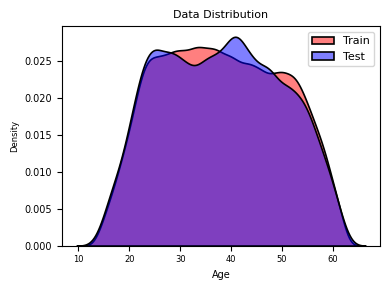

In [26]:
plt.figure(figsize=(4, 3))
sns.kdeplot(data=train_data, x='age', fill=True, common_norm=False, alpha=0.5, label='Train', color='red', edgecolor='black', linewidth=1.2)
sns.kdeplot(data=test_data, x='age', fill=True, common_norm=False, alpha=0.5, label='Test', color='blue', edgecolor='black', linewidth=1.2)
plt.title('Data Distribution', fontsize=8)
plt.xlabel('Age', fontsize=7)
plt.xticks(fontsize=6)
plt.ylabel('Density', fontsize=6)
plt.yticks(fontsize=7)
plt.legend(fontsize='8')
plt.tight_layout()
plt.show()

In [27]:
len(train_data)

130494

In [28]:
np.random.seed(42)
train_unique_names = train_data['name'].unique()

retain_names = np.random.choice(train_unique_names, size=int(len(train_unique_names) * 0.8), replace=False)
forget_names = np.setdiff1d(train_unique_names, retain_names)

# Assign records to retain_data and forget_data based on the names
retain_data = train_data[train_data['name'].isin(retain_names)]
forget_data = train_data[train_data['name'].isin(forget_names)]

len(retain_data), len(forget_data)

(105090, 25404)

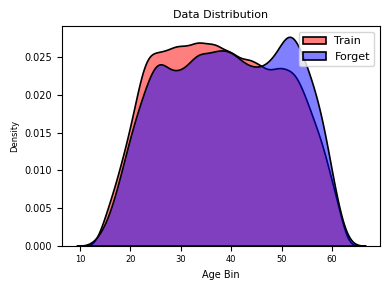

In [29]:
plt.figure(figsize=(4, 3))
sns.kdeplot(data=train_data, x='age', fill=True, common_norm=False, alpha=0.5, label='Train', color='red', edgecolor='black', linewidth=1.2)
sns.kdeplot(data=forget_data, x='age', fill=True, common_norm=False, alpha=0.5, label='Forget', color='blue', edgecolor='black', linewidth=1.2)
# sns.countplot(x='age_bin', data=train_data, color='red', width=0.8, edgecolor='black')
# sns.countplot(x='age_bin', data=forget_data, color='blue', width=0.8, edgecolor='black')
plt.title('Data Distribution', fontsize=8)
plt.xlabel('Age Bin', fontsize=7)
plt.xticks(fontsize=6)
plt.ylabel('Density', fontsize=6)
plt.yticks(fontsize=7)
plt.legend(fontsize='8')
plt.tight_layout()
plt.show()

In [30]:
train_data.to_csv("./celeb-data/train.csv", index=False)
test_data.to_csv("./celeb-data/test.csv", index=False)
retain_data.to_csv('./celeb-data/retain.csv', index=False)
forget_data.to_csv('./celeb-data/forget.csv', index=False)

## PyTorch Dataset

In [15]:
from typing import Optional
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import lightning as L
from lightning.pytorch.utilities.types import TRAIN_DATALOADERS, EVAL_DATALOADERS

/home/omkarvijaypitale/miniconda3/envs/aml-cloud/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [31]:
class CARCDataset(Dataset):
    def __init__(
        self,
        image_dir: str,
        data_file: str, 
        transform,
        device: str,
    ):
        self.image_dir = image_dir
        self.data = pd.read_csv(data_file)
        self.transform = transform
        self.device = device 

    def __len__(self):
        return len(self.data) 
    
    def __getitem__(self, idx):
        name = self.data.iloc[idx]['name']
        image_path = self.data.iloc[idx]['file']
        label = self.data.iloc[idx]['age_bin']
        
        img = Image.open(os.path.join(self.image_dir, image_path))
        img = self.transform(img)
        
        return name, img.to(device=self.device), torch.tensor(label, device=self.device)

In [36]:
class CARCDataModule(L.LightningDataModule):
    def __init__(
        self, 
        image_dir: str,
        data_files: dict[str],
        batch_size: int,
        num_workers: int, 
        device: str
    ) -> None: 
        
        super(CARCDataModule, self).__init__()
        self.save_hyperparameters(logger=True)
        
        self.image_dir = image_dir
        self.data_files = data_files 
        self.batch_size = batch_size 
        self.num_workers = num_workers
        
        self.transform = transforms.Compose([
            transforms.ToTensor()
        ])
        
        self.device = device
        
    def setup(self, stage: Optional[str] = None) -> None:
        self.train_dataset =  CARCDataset(
            image_dir=self.image_dir,
            data_file=self.data_files['train'],
            transform=self.transform,
            device=self.device
        ) 
        
        self.test_dataset = CARCDataset(
            image_dir=self.image_dir,
            data_file=self.data_files['test'], 
            transform=self.transform,
            device=self.device
        )
    
    def train_dataloader(self) -> TRAIN_DATALOADERS:
        return DataLoader(
            dataset=self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True
        )
    
    def val_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(
            dataset=self.test_dataset,
            batch_size=self.batch_size,
        )
    
    def test_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(
            dataset=self.test_dataset,
            batch_size=self.batch_size,
        )

In [37]:
dm = CARCDataModule(
    image_dir='./CACD2000',
    data_files={
        'train': './celeb-data/train.csv',
        'test': './celeb-data/test.csv'
    },
    batch_size=32,
    num_workers=4,
    device='cuda'
)

In [38]:
dm.setup()

In [40]:
batch = next(iter(dm.train_dataloader()))

In [41]:
names, imgs, labels = batch

In [42]:
imgs.size(), labels.size()

(torch.Size([32, 3, 250, 250]), torch.Size([32]))